In [1]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 12.3 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.42.1-py3-n

In [69]:
import numpy as np
import random
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import UGate
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import HGate
# from qiskit.circuit.gate import ControlledGate

# QFT and QPE

In [137]:
def QFT(len_x):
  qr_x = QuantumRegister(len_x,"x")

  qc = QuantumCircuit(qr_x)
  # qc.x(0)
  # qc.x(2)
  for i in range(0,len_x):
    qc.barrier()
    qc.h(qr_x[i])
    c=0
    
    # print("h")
    for j in range(i+1,len_x):
      c=c+1
      qc.cp(np.pi/(2**(c)),qr_x[i],qr_x[j])
   
  return qc

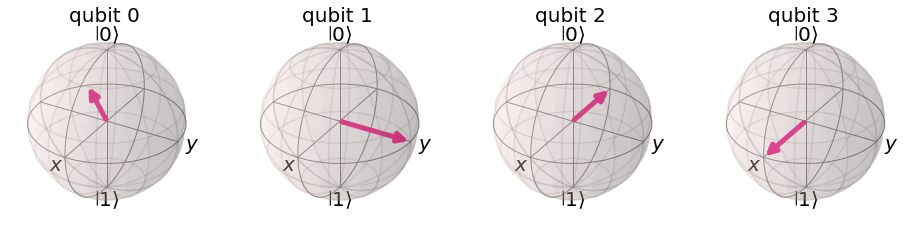

In [ ]:
from qiskit import Aer
from qiskit.visualization import plot_bloch_multivector

backend = Aer.get_backend('statevector_simulator')

state = execute(QFT(4),backend).result().get_statevector()
plot_bloch_multivector(state)

In [138]:
def QPE(gate, len_pr):
  '''
  Input a gate in the 'gate' section and length of circuit in 'len' circuit
  '''

  qr_pr = QuantumRegister(len_pr, "precession_bits")
  qr_op = QuantumRegister(1, "operator")
  # cr = ClassicalRegister(len_pr)

  qc = QuantumCircuit(qr_pr, qr_op)
  qc.h(qr_pr)

  for i in range(0,len_pr):
    for j in range(0,2**i):
      # qc.cp(np.pi/4, qr_pr[i],qr_op[0])
      qc.append(gate.control(1),[qr_pr[i],qr_op[0]])
  
  qfti = QFT(lenn).inverse()
  qc.append(qfti, list(range(0,lenn)))

  return qc

# Final HHL Implementation

$$A = \begin{pmatrix}1& -\frac{1}{3}\\-\frac{1}{3} & 1\\\end{pmatrix}$$

$$ b =  \begin{pmatrix}0 \\ 1\\\end{pmatrix}$$

and one can calcualte the solution to be 

$$ x =  \begin{pmatrix} \frac{3}{8} \\ \frac{9}{8}\\\end{pmatrix}$$

we can observe that $\frac{|x_0|^2}{|x_1|^2} = \frac{1}{9}$. This is what we will obseve later in our result. 


Basic matrix diagonaisation can be used such that the U for QPE can be obtained as  $\frac{1}{2}\begin{pmatrix}-1+i& 1+i\\1+i & -1+i\\\end{pmatrix}$

In [135]:
## final circuit

# this is the gate for the rotation
U = Operator([[complex(-1,1)*0.5,complex(1,1)*0.5],[complex(1,1)*0.5,complex(-1,1)*0.5]]).to_instruction()


qr_a = QuantumRegister(1,"qr_a")
qr_l = QuantumRegister(2, "qr_l")
qr_b = QuantumRegister(1, "qt_b")
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr_a, qr_l, qr_b, cr)

qc.barrier()
qc.x(qr_b[0])
qc.barrier()
qc.append(QPE(U, 2), [1,2,3])
# 
qc.barrier()
qc.cry(np.pi,qr_l[0],qr_a[0])
qc.cry(np.pi/3,qr_l[1],qr_a[0])
qc.barrier()
qc.append(QPE(U, 2).inverse(), [1,2,3])
qc.barrier()

qc.measure([qr_a[0],qr_b[0]], [cr[0],cr[1]])
# qc.transpile()
qc.draw()

░       ░                   ░ ┌───────┐┌─────────┐ ░ »
  qr_a: ─░───────░───────────────────░─┤ Ry(π) ├┤ Ry(π/3) ├─░─»
         ░       ░ ┌───────────────┐ ░ └───┬───┘└────┬────┘ ░ »
qr_l_0: ─░───────░─┤0              ├─░─────■─────────┼──────░─»
         ░       ░ │               │ ░               │      ░ »
qr_l_1: ─░───────░─┤1 circuit-4530 ├─░───────────────■──────░─»
         ░ ┌───┐ ░ │               │ ░                      ░ »
  qt_b: ─░─┤ X ├─░─┤2              ├─░──────────────────────░─»
         ░ └───┘ ░ └───────────────┘ ░                      ░ »
c106: 2/══════════════════════════════════════════════════════»
                                                              »
«                             ░ ┌─┐   
«  qr_a: ─────────────────────░─┤M├───
«        ┌──────────────────┐ ░ └╥┘   
«qr_l_0: ┤0                 ├─░──╫────
«        │                  │ ░  ║    
«qr_l_1: ┤1 circuit-4597_dg ├─░──╫────
«        │                  │ ░  ║ ┌─┐
«  qt_b: ┤2                 ├─░──╫─┤M├
«        └──────────────────┘ ░  ║ └╥┘
«c106: 2/════════════════════════╩══╩═
«                                0  1

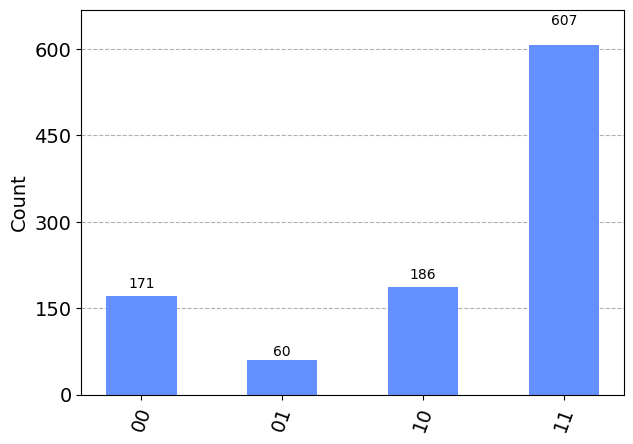

In [136]:
backend = Aer.get_backend('qasm_simulator')

counts = execute(qc,backend, counts = 1024).result().get_counts()
plot_histogram(counts)

Considering only the case where qr_a is in |1> state we can observe that the $\frac{|x_0|^2}{|x_1|^2} \approx \frac{1}{9}$